# Singular Value Thresholding (SVT)
Singular Value Thresholding is a denoising method based on low-rank matrix approximation. It is used for matrix completion and denoising by shrinking the singular values. This method is similar to PCA, as both methods focus on extracting the most significant components of the matrix.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import seaborn as sns
from sklearn.decomposition import PCA
import math
from skimage.metrics import structural_similarity as ssim
from numpy.linalg import svd

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def collect_windows(matrix, window_size):
    """ Extracts all sliding windows from the matrix for PCA. """
    m, n = matrix.shape
    windows = []

    for i in range(0, m - window_size + 1):
        for j in range(0, n - window_size + 1):
            window = matrix[i:i+window_size, j:j+window_size].flatten()
            windows.append(window)  # Collect all windows

    return np.array(windows)

def svt(matrix, threshold):
    U, S, Vt = svd(matrix, full_matrices=False)
    S_thresholded = np.maximum(S - threshold, 0)  # Shrink singular values
    return np.dot(U, np.dot(np.diag(S_thresholded), Vt))

def clip_rotate(matrix):
    zm = clipped_zoom(matrix, 0.7)
    rot_clipped = ndi.rotate(zm, 45, reshape=False)
    return rot_clipped

In [3]:
winsize = "3mb"
wdir = "../data/dlbcl/"
region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

gained = pd.read_csv(wdir + 'gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

reg = 1448

window_start, window_end = regions.loc[reg][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v
print("loaded hic")

loaded hic


In [4]:
# Set window size
threshold = 0.04

# raw matrices
rot_patient = clip_rotate(patient_region_sub)

rot_control = clip_rotate(control_region_sub)

# Apply PCA
pca_matrix1 = svt(patient_region_sub, threshold)
rot_pca1 = clip_rotate(pca_matrix1) 

pca_matrix2 = svt(control_region_sub, threshold)
rot_pca2 = clip_rotate(pca_matrix2)

# Compute PCA difference matrix (patient - control)
diff_pca1 = pca_matrix1 - pca_matrix2 # pca_matrix1 - pca_matrix2
rot_diff_pca1 = clip_rotate(diff_pca1)

# subtract inverse (control - patient)
diff_pca2 = pca_matrix2 - pca_matrix1
rot_diff_pca2 = clip_rotate(diff_pca2)

# log2(obs/exp) calc
safe_div = pca_matrix1 / pca_matrix2
safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_pca1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied
rot_log_pca1 = clip_rotate(log_pca1)

log_pca2 =  np.log2(patient_region_sub / control_region_sub) # pca_matrix1 / pca_matrix2 of normal matrices
rot_log_pca2 = clip_rotate(log_pca2)

Plot saved to out/svt_hic.png


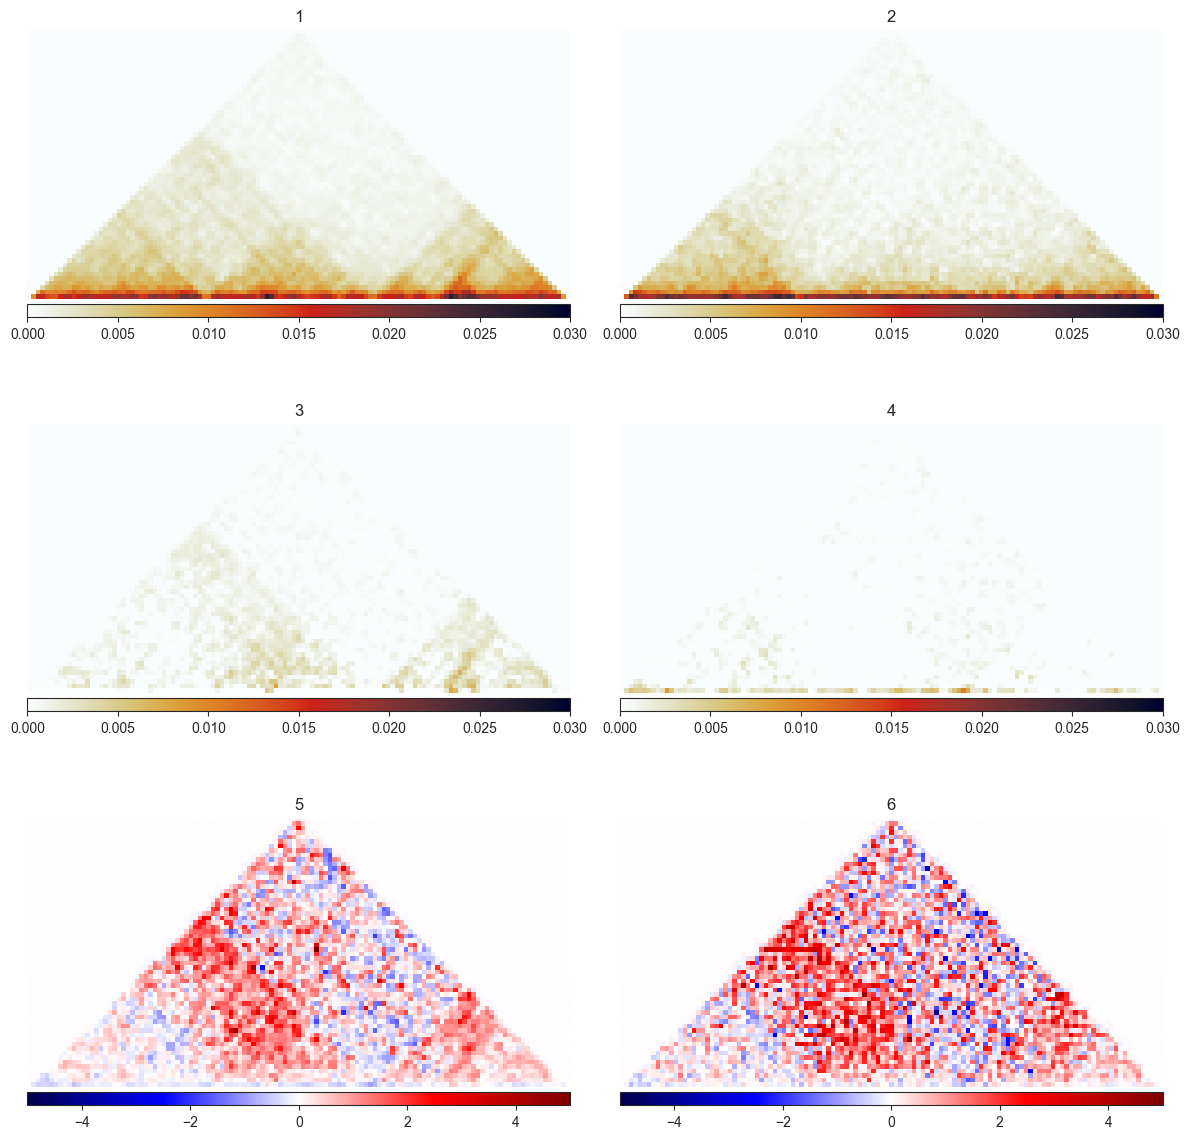

In [5]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

middle = int(np.shape(rot_control)[1]/ 2.)

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(rot_diff_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(rot_log_pca1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(rot_log_pca2[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "svt_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")

## single figure

Plot saved to out/svt_hic.png


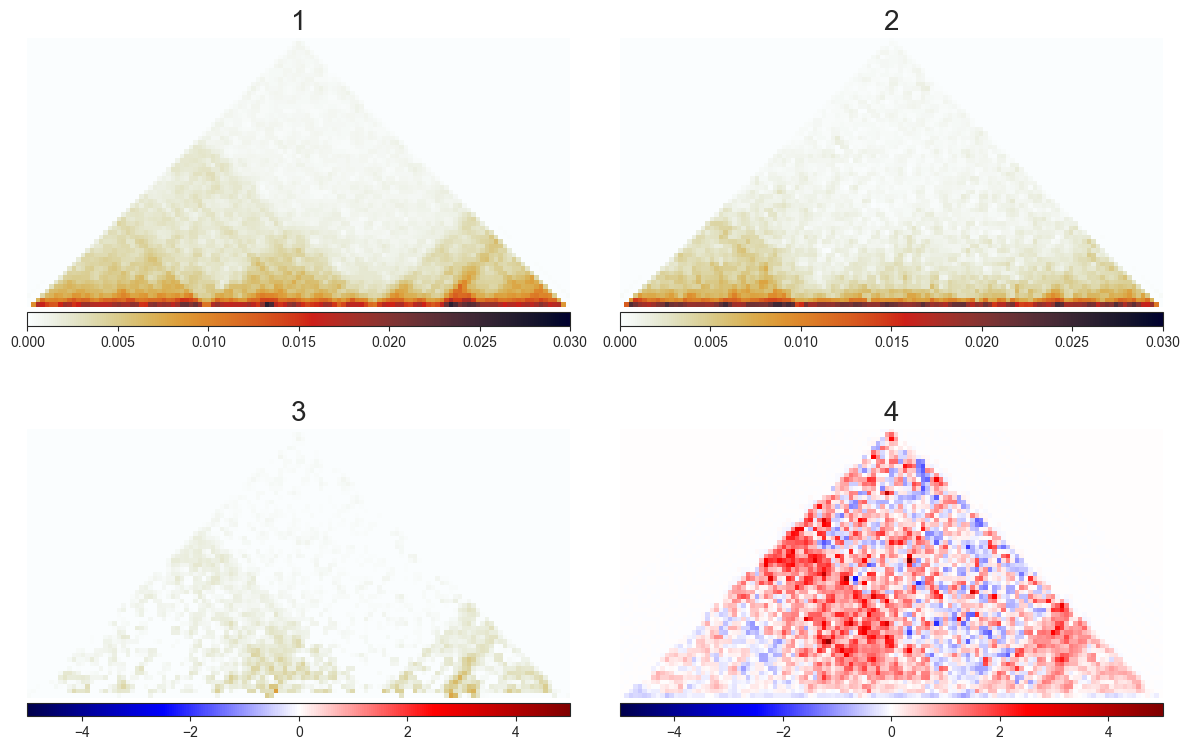

In [6]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

middle = int(np.shape(rot_control)[1]/ 2.)

# First row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1", fontsize=20)

m2 = axes[0][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2", fontsize=20)

# Second row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3", fontsize=20)

m4 = axes[1][1].imshow(rot_log_pca1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[1, 1].set_title("4", fontsize=20)


color_bars = [m1, m2, m3, m4]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "svt_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")

## compute stats
compute ssim, rmse, explanied variance

In [7]:
def mean_squared_error(matrix_1, matrix_2):
    return np.mean((matrix_1 - matrix_2) ** 2)

def root_mean_squared_error(matrix_1, matrix_2):
    return np.sqrt(mean_squared_error(matrix_1, matrix_2))

def structural_similarity(matrix_1, matrix_2):
    return ssim(matrix_1, matrix_2, data_range=matrix_1.max() - matrix_1.min())

def explained_variance_score(matrix_1, matrix_2):
    variance_original = np.var(matrix_1)
    variance_error = np.var(matrix_1 - matrix_2)
    return 1 - (variance_error / variance_original)

print("stats for patient")

matrix_1 = patient_region_sub
matrix_2 = pca_matrix1

# print("MSE:", mean_squared_error(matrix_1, matrix_2)) # Lower MSE indicates better denoising.
print("RMSE:", root_mean_squared_error(matrix_1, matrix_2)) # More interpretable than MSE since it has the same units as the matrix values.
print("SSIM:", structural_similarity(matrix_1, matrix_2)) # Values closer to 1 indicate better denoising. Useful for image-like matrix data.
#print("PSNR:", peak_signal_to_noise_ratio(matrix_1, matrix_2)) # Higher PSNR means better denoising.
print("Explained Variance:", explained_variance_score(matrix_1, matrix_2)) # Closer to 1 means better denoising.
#print("Frobenius Norm Error:", frobenius_norm_error(matrix_1, matrix_2)) # Lower values indicate better denoising.

print("----------")
print("stats for control")

matrix_1 = control_region_sub
matrix_2 = pca_matrix2

print("RMSE:", root_mean_squared_error(matrix_1, matrix_2)) # More interpretable than MSE since it has the same units as the matrix values.
print("SSIM:", structural_similarity(matrix_1, matrix_2)) # Values closer to 1 indicate better denoising. Useful for image-like matrix data.
print("Explained Variance:", explained_variance_score(matrix_1, matrix_2)) # Closer to 1 means better denoising.

# not solid stats
#print("PSNR:", peak_signal_to_noise_ratio(matrix_1, matrix_2)) # Higher PSNR means better denoising.
#print("Frobenius Norm Error:", frobenius_norm_error(matrix_1, matrix_2)) # Lower values indicate better denoising.

stats for patient
RMSE: 0.002485035109289444
SSIM: 0.8781677258370684
Explained Variance: 0.8326963633963829
----------
stats for control
RMSE: 0.0026973264071887834
SSIM: 0.8805868416864833
Explained Variance: 0.847643967056996
